In [4]:
# try:
#     import KDEpy
# except ImportError:
#     !pip install KDEpy
#     import KDEpy
# try:
#     import osmnx as ox
# except ImportError:
#     !pip install osmnx
#     import osmnx as ox
# !pip install -U matplotlib
# from KDEpy import FFTKDE
import osmnx as ox
from scipy.interpolate import interp1d
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from shapely.geometry import Polygon, LineString, Point
import geopandas as gpd
import pandas as pd

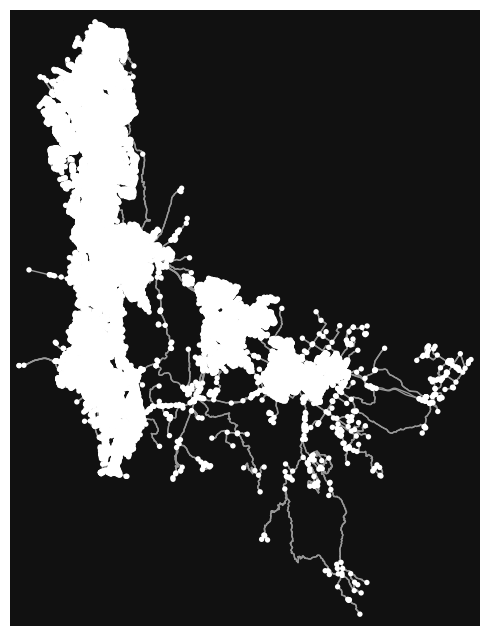

In [5]:
G = ox.graph_from_place('Alameda', network_type='drive', buffer_dist=10)
graph_proj = ox.project_graph(G, to_crs="EPSG:2805")
fig, ax = ox.plot_graph(graph_proj)
nodes, edges = ox.graph_to_gdfs(graph_proj)
test = edges["geometry"]
buff = test.buffer(100)

In [6]:
import glob
import os

path="FARS CSVs/"

all_files = glob.glob(os.path.join(path, "*.CSV"))


li = []

for filename in all_files:
    fars_dfi = pd.read_csv(filename, encoding_errors='ignore', dtype={'LATITUDE': float, 'LONGITUD': float})
    
    try:
        fars_dfi = fars_dfi[fars_dfi["LATITUDENAME"] != "Reported as Unknown"]
    except:
        continue
    try:
            fars_dfi = fars_dfi[fars_dfi["LONGITUDNAME"] != "Reported as Unknown"]
    except:
        continue
    fars_dfi = fars_dfi.rename(columns={'LATITUDE': 'lat','LONGITUD': 'lon'})
    li.append(fars_dfi[["lat", "lon"]])
fars_df_all = pd.concat(li, axis=0, ignore_index=True)
FARS_GDF = gpd.GeoSeries(fars_df_all.loc[:, ["lon", "lat"]].apply(Point, axis=1), crs = "epsg:4326")
FARS_GDF = FARS_GDF.to_crs("EPSG:2805")
minx, miny, maxx, maxy = buff.total_bounds
LTC = Point(minx, maxy)
RTC = Point(maxx, maxy)
LBC = Point(minx, miny)
RBC = Point(maxx, miny)
box = Polygon([LTC,RTC,RBC,LBC])
holder = []
FARS_HOLDER = []
for i in FARS_GDF:
    if box.contains(i):
        FARS_HOLDER.append(i)
fars_gpd = gpd.GeoSeries(FARS_HOLDER)

/var/folders/ld/0d4wkzhx35l9n938_38xg4w00000gn/T/ipykernel_55396/3676781781.py:12: DtypeWarning: Columns (40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  fars_dfi = pd.read_csv(filename, encoding_errors='ignore', dtype={'LATITUDE': float, 'LONGITUD': float})
/var/folders/ld/0d4wkzhx35l9n938_38xg4w00000gn/T/ipykernel_55396/3676781781.py:12: DtypeWarning: Columns (40,42) have mixed types. Specify dtype option on import or set low_memory=False.
  fars_dfi = pd.read_csv(filename, encoding_errors='ignore', dtype={'LATITUDE': float, 'LONGITUD': float})


In [15]:
SDS_test = pd.read_csv("California.csv", encoding_errors='ignore')

SDS_test["LATITUDE"] = pd.to_numeric(SDS_test["LATITUDE"], errors='coerce')
SDS_test["LONGITUDE"] = pd.to_numeric(SDS_test["LONGITUDE"], errors='coerce')


/var/folders/ld/0d4wkzhx35l9n938_38xg4w00000gn/T/ipykernel_55396/4282056771.py:1: DtypeWarning: Columns (4,7,8,15,16,18,21,27,30,31,33,34,35,37,43,55,75) have mixed types. Specify dtype option on import or set low_memory=False.
  SDS_test = pd.read_csv("California.csv", encoding_errors='ignore')


In [16]:
SDS_test = SDS_test.dropna(subset=['LATITUDE','LONGITUDE'])

In [17]:
SDS_test["LONGITUDE"]

0          119.62345
2          117.90722
5          119.01829
9          117.83136
12         122.63129
             ...    
2298582    120.99367
2298583    120.82905
2298584    117.11260
2298585    117.33046
2298586    120.82699
Name: LONGITUDE, Length: 1414384, dtype: float64

In [19]:
# try:
#     SDS_test = SDS_test[SDS_test["LATITUDENAME"] != "Reported as Unknown"]
# except:
#     pass
# try:
#     SDS_test = SDS_test[SDS_test["LONGITUDNAME"] != "Reported as Unknown"]
# except:
#     pass


SDS_test = SDS_test.rename(columns={'LATITUDE': 'lat','LONGITUDE': 'lon'})
li.append(SDS_test[["lat", "lon"]])
fars_df_all = pd.concat(li, axis=0, ignore_index=True)
FARS_GDF = gpd.GeoSeries(fars_df_all.loc[:, ["lon", "lat"]].apply(Point, axis=1), crs = "epsg:4326")
FARS_GDF = FARS_GDF.to_crs("EPSG:2805")

In [20]:
len(fars_gpd)

1143

<AxesSubplot: >

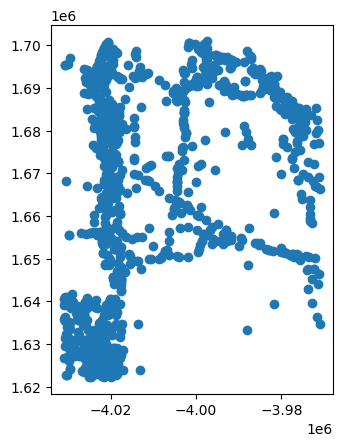

In [21]:
fars_gpd.plot()

In [22]:
class batch():
    
    def __init__(self, area):
     
        self.area = area  #buffer area
        self.fars_gdf = [] #points within buffer
        self.minx = 0
        self.miny = 0
        self.maxx = 0
        self.maxy = 0
        self.f =0 
        self.xx = 0
        self.yy = 0
    def add_point(self, point):
        self.fars_gdf.append(point)
    def calc_KDE(self):
        self.minx, self.miny, self.maxx, self.maxy = area.bounds
        self.xx, self.yy = np.mgrid[minx:maxx:100j, miny:maxy:100j]
        positions = np.vstack([self.xx.ravel(), self.yy.ravel()])
        list_ver = []
        for i,j in enumerate(self.fars_gdf):
            list_ver.append([j.x, j.y])
        T_fars = np.array(list_ver).transpose()
        
        kernel = st.gaussian_kde(T_fars, bw_method="silverman")
        self.f = np.reshape(kernel(positions).T, self.xx.shape)
        return self.f, self.minx, self.miny, self.maxx, self.maxy

In [23]:
batches = []
for i, area in enumerate(buff):
    batches.append(batch(area))
for point in fars_gpd:
    for batch in batches:
        if point.within(batch.area):
            batch.add_point(point)

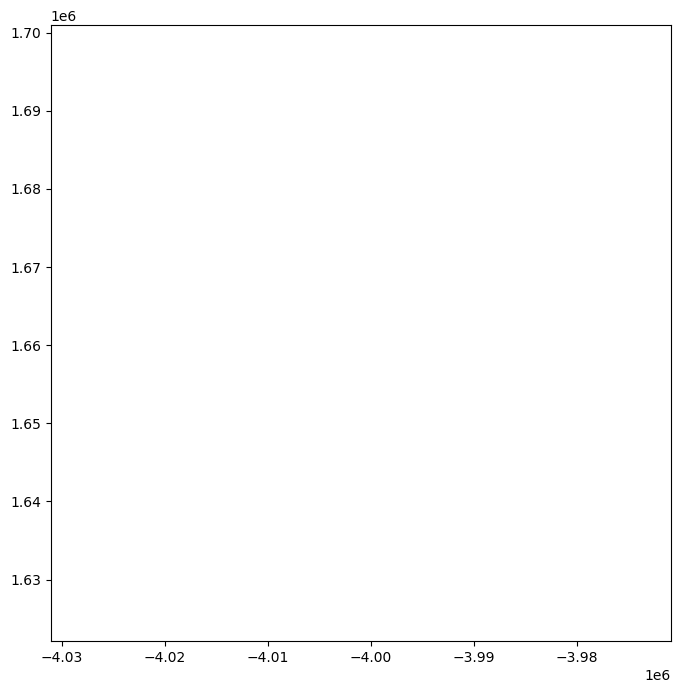

In [24]:
fig = plt.figure(figsize=(8,8))
xx, yy = np.mgrid[minx:maxx:100j, miny:maxy:100j]
ax = fig.gca()
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
#cfset = ax.contourf(xx, yy, f, cmap='cool')
for i in batches:
    if len(i.fars_gdf) >3:
        f, selfminx, selfminy, selfmaxx, selfmaxy = i.calc_KDE()
        

In [25]:
def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"

    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0.0, 0.9,N+4)
    return mycmap

In [26]:
#fig, ax = ox.plot_graph(graph_proj)
mycmap = transparent_cmap(plt.cm.Blues)
fig = plt.figure(figsize=(50,50))
ax = fig.gca()
t = 0

test.plot(ax=ax,color='Red')
for j,i in enumerate(batches):
    if len(i.fars_gdf) >3:
        t += 1
        cfset = ax.contourf(i.xx, i.yy, i.f, cmap=mycmap)
        #cset = ax.contour(i.xx, i.yy, i.f, colors="Blue")

In [ ]:
fig = plt.figure(figsize=(50,50))
ax = fig.gca()

buff.plot(ax=ax, color='Black')
fars_gpd.plot(ax=ax, color="Yellow")